In [1]:
import numpy as np
import cupy as cp
import scipy
from scipy import ndimage
from scipy.linalg import expm
import os
import matplotlib.pyplot as plt
import cv2 as cv
import random
from itertools import product
from sklearn.metrics import roc_curve, roc_auc_score

In [2]:
num_of_writers = 1
num_of_writers_for_development_phase = 7
num_of_writers_for_testing_phase = 3

percent_of_genuine_signatures_for_development_set = 0.7
percent_of_forged_signatures_for_development_set = 0.7
num_of_genuine_signatures_per_writer = 24
num_of_forged_signatures_per_writer = 30
num_genuine_to_select = int(num_of_genuine_signatures_per_writer * percent_of_genuine_signatures_for_development_set)
num_forged_to_select = int(num_of_forged_signatures_per_writer * percent_of_forged_signatures_for_development_set)


#### Loading database images

In [3]:
signature_database_path = 'C:\\Users\\ester\\faculdade\\tcc\\database_gpds\\SignatureGPDSSyntheticSignaturesManuscripts\\firmasSINTESISmanuscritas\\'
prefix_of_genuine_signatures = "c-"
prefix_of_forged_signatures = "cf-"

In [4]:
def load_image(image_path):
    image = cv.imread(image_path)
    gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    image_array = np.array(gray_image)

    return image_array

In [5]:
def load_data(directory_path, num_of_individuals):
    data = []
    individuals_counter = 0

    for subdir, _, files in os.walk(directory_path):
        if subdir == directory_path:
            continue

        individual = os.path.basename(subdir)
        
        genuine_signatures = [load_image(os.path.join(directory_path, subdir, file)) for file in files if file.startswith(prefix_of_genuine_signatures)]
        forged_signatures = [load_image(os.path.join(directory_path, subdir, file)) for file in files if file.startswith(prefix_of_forged_signatures)]
        
        data.append({
            'individual': int(individual),
            'genuine_signatures': genuine_signatures,
            'forged_signatures': forged_signatures
        })

        individuals_counter += 1

        if individuals_counter == num_of_individuals:
            break
    
    return data

In [6]:
data = load_data(signature_database_path, num_of_writers)

In [13]:
some_sig = data[0]['genuine_signatures'][23]

In [16]:
some_sig.shape

(333, 1250)

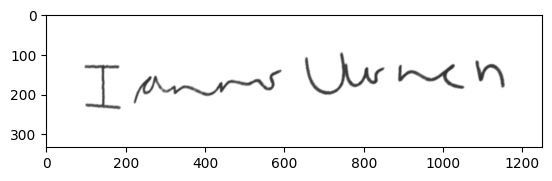

In [14]:
plt.imshow(some_sig, cmap='gray', vmin=0, vmax=255)

In [63]:
otsued = otsu_thresholding(some_sig)

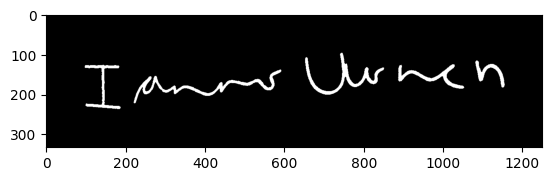

In [64]:
plt.imshow(otsued, cmap='gray', vmin=0, vmax=1)

#### Applying pre-processing

In [17]:
def thin_operation(img, th_level):
    '''
    Aplica th_level operações de dilatação e, em seguida, th_level operações de
    erosão na imagem img.
    Recebe um ndarray contendo uma máscara binária de uma imagem.
    Devolve uma máscara binária também, com o resultado da operação.
    '''
        
    img = ndimage.binary_opening(img, iterations=th_level)
    img = ndimage.binary_erosion(img, iterations=th_level)
        
    return img.astype(int)

In [18]:
def otsu_thresholding(image_array):
    _, otsu_result = cv.threshold(image_array, 0, 1, cv.THRESH_BINARY + cv.THRESH_OTSU)
    otsu_inverted = otsu_result^1

    return otsu_inverted

In [19]:
def calculate_ld(image):
    '''
    Calculates patch density for each 5x5 patch centered at a signature pixel.
    Receives as input a binary mask. Returns an array with densities.
    '''

    ld = []
    pad = 2
    padded_image = np.pad(image, pad, mode='constant', constant_values=0)
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if image[i, j] == 1:
                patch = padded_image[i:i+5, j:j+5]
                patch_density = np.sum(patch) / 25
                ld.append(patch_density)
    
    if len(ld) == 0:
        ld.append(0)
                
    return np.array(ld)

In [20]:
def get_optimal_thinning_level(image_array):
    pd = []
    th_level = 0

    while True:
        thinned_image = thin_operation(image_array, th_level)

        ld = calculate_ld(thinned_image)
        ld_mean = np.mean(ld)
        if len(pd) > 1 and np.abs(pd[-1] - ld_mean) < 0.12:
            break
        pd.append(ld_mean)
        th_level += 1

    pd_diff = np.abs(np.diff(pd))
    otl = np.argmax(pd_diff) + 1

    return otl

In [21]:
def get_most_optimal_thinning_level(genuine_signatures_of_an_individual_preprocessed_with_ostu):
    otl = []
    index = 0
    for signature_image in genuine_signatures_of_an_individual_preprocessed_with_ostu:

        signature_otl = get_optimal_thinning_level(signature_image)
        
        otl.append(signature_otl)
        index += 1
    
    motl = np.mean(otl)

    return motl

In [22]:
for individual_data in data:

    preprocessed_genuine_signatures = []
    for sig in individual_data['genuine_signatures']:
        otsu_sig = otsu_thresholding(sig)
        preprocessed_genuine_signatures.append(otsu_sig)

    preprocessed_forged_signatures = []
    for sig in individual_data['forged_signatures']:
        otsu_sig = otsu_thresholding(sig)
        preprocessed_forged_signatures.append(otsu_sig)

    motl = get_most_optimal_thinning_level(preprocessed_genuine_signatures)
    individual_data['motl'] = round(motl)

    individual_data['genuine_signatures_mask'] = \
        list(map(lambda sig: thin_operation(sig, individual_data['motl']), preprocessed_genuine_signatures))
    
    individual_data['forged_signatures_mask'] = \
        list(map(lambda sig: thin_operation(sig, individual_data['motl']), preprocessed_forged_signatures))


In [29]:
np.median(data[0]['genuine_signatures_mask'][23])

0.0

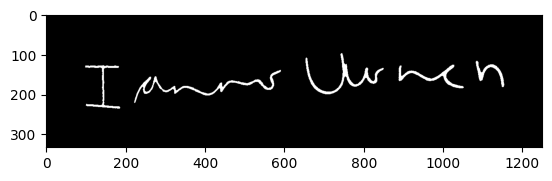

In [30]:
plt.imshow(data[0]['genuine_signatures_mask'][23], cmap='gray', vmin=0, vmax=1)

In [59]:
center_of_mass = ndimage.measurements.center_of_mass(data[0]['genuine_signatures_mask'][23])

C:\Users\ester\AppData\Local\Temp\ipykernel_8564\1392648878.py:1: DeprecationWarning: Please import `center_of_mass` from the `scipy.ndimage` namespace; the `scipy.ndimage.measurements` namespace is deprecated and will be removed in SciPy 2.0.0.
  center_of_mass = ndimage.measurements.center_of_mass(data[0]['genuine_signatures_mask'][23])


In [62]:
data[0]['genuine_signatures_mask'][23].shape
#center_of_mass

(333, 1250)

In [ ]:

    # Calculate center of mass
center_of_mass = ndimage.measurements.center_of_mass(image)


# Shift the image
shifted_image = ndimage.shift(image, shift)


img_array = load_image(image_path)
center_of_mass = calculate_center_of_mass(img_array)

shift = np.array(output_size) / 2 - np.array(center_of_mass)

shifted_image = shift_image(img_array, shift)

# Create a larger canvas
larger_canvas = np.zeros(output_size, dtype=np.uint8)

# Calculate position to paste the shifted image onto the larger canvas
paste_position = tuple((np.array(output_size) - np.array(img_array.shape)) // 2)

# Paste the shifted image onto the larger canvas
larger_canvas[paste_position[0]:paste_position[0]+img_array.shape[0], 
                paste_position[1]:paste_position[1]+img_array.shape[1]] = shifted_image

# Convert back to image
centered_image = Image.fromarray(larger_canvas)

return centered_image

# Example usage:
image_path = 'your_image.jpg'  # Path to your input image
output_size = (800, 600)  # Desired output size of the canvas
centered_image = centerize_image(image_path, output_size)
centered_image.show()  # Display the resulting image


In [32]:
COVARIANCE_MATRICES_PATH = 'dictionaries-of-scm-original-preproc-complete\\'

In [34]:
import pickle
WRITERS_PER_FILE = 5

def load_scm(directory_path, num_of_files_to_load = None, num_of_writers_to_load = None):
    '''
    Parametros:
    - directory_path -> diretório com os arquivos pickle contendo as
        matrizes de covariância.
    - num_of_files_to_load -> quantidade de arquivos a serem carregados.
        Cada arquivo possui as matrizes de covariância de 200 indivíduos.
    '''
    count = 0
    data = {}

    if num_of_files_to_load != None:
        for _, _, files in os.walk(directory_path):

            for file in files:
                if count == num_of_files_to_load:
                    break
                
                try:
                    with open(os.path.join(directory_path, file), 'rb') as pickle_file:
                        print(file)
                        pickle_file.seek(0)
                        loaded_data = pickle.load(pickle_file)
                        data.update(loaded_data)

                except Exception as e:
                    continue

                count += 1
    
    elif num_of_writers_to_load != None:
        remaining = num_of_writers_to_load

        for _, _, files in os.walk(directory_path):
            while len(data.keys()) != num_of_writers_to_load:
                file = random.choice(files)

                with open(os.path.join(directory_path, file), 'rb') as pickle_file:
                    pickle_file.seek(0)

                    num_writers = WRITERS_PER_FILE if remaining - WRITERS_PER_FILE > 0 else remaining

                    loaded_data = pickle.load(pickle_file)
                    
                    writers = random.sample(list(loaded_data.items()), num_writers)

                    for writer in writers:
                        data.update({writer[0]: writer[1]})

                    remaining -= WRITERS_PER_FILE
                    
                    if remaining <= 0:
                        break

                count += 1
    
    return data

In [35]:
dataseto = load_scm(COVARIANCE_MATRICES_PATH, num_of_writers_to_load=1)

In [57]:
np.max(dataseto[534]['genuine_scm'][18])

0.04702885916943734

#### Calculate covariance matrices

In [16]:
def calculate_feature_map(image, binary_mask):

    image = image / 255.0
    h, w = image.shape
    Ix = np.gradient(image, axis=1)
    Iy = np.gradient(image, axis=0)
    Ixx = np.gradient(Ix, axis=1)
    Ixy = np.gradient(Ix, axis=0)
    Iyy = np.gradient(Iy, axis=0)
    gradient_magnitude = np.sqrt(Ix**2 + Iy**2)
    gradient_direction = np.arctan2(Iy, Ix)
    xn = np.tile(np.arange(w) / w, (h, 1))
    yn = np.tile(np.arange(h) / h, (w, 1)).T

    feature_map = np.stack([
        image, Ix, Iy, Ixx, Ixy, Iyy, gradient_magnitude, gradient_direction, xn, yn
    ], axis=0)

    feature_map_only_signature_pixels = feature_map * binary_mask[np.newaxis, :, :]
    
    return feature_map_only_signature_pixels

def calculate_signature_covariance_matrix(feature_map):

    feature_map = feature_map.reshape(10, -1)

    S = feature_map.shape[1]
    mu = np.mean(feature_map, axis=1, keepdims=True)

    inner_summup = (feature_map - mu) @ (feature_map - mu).T
    covariance_matrix = (1 / (S - 1)) * inner_summup
    
    return covariance_matrix

In [58]:
import os
import random
from PIL import Image

# Path to the main folder containing inner folders
main_folder = "path/to/main/folder"

# Get a list of inner folders
inner_folders = [folder for folder in os.listdir(main_folder) if os.path.isdir(os.path.join(main_folder, folder))]

# Randomly select 500 inner folders
#selected_folders = random.sample(inner_folders, 500)

# Initialize variables to keep track of the maximum dimensions
max_width = 0
max_height = 0

# Loop through each selected inner folder
for i, folder in enumerate(inner_folders, start=1):
    # Get a list of image files in the inner folder
    images = [img for img in os.listdir(os.path.join(main_folder, folder)) if img.endswith(('.jpg', '.jpeg', '.png'))]

    # Loop through each image in the inner folder
    for img_file in images:
        # Load the image
        img_path = os.path.join(main_folder, folder, img_file)
        image = Image.open(img_path)

        # Get the dimensions of the image
        width, height = image.size

        # Update the maximum dimensions if necessary
        max_width = max(max_width, width)
        max_height = max(max_height, height)

# Now you have the maximum dimensions
print("Maximum Width:", max_width)
print("Maximum Height:", max_height)


FileNotFoundError: [WinError 3] O sistema não pode encontrar o caminho especificado: 'path/to/main/folder'

In [17]:
for individual_data in data:

    genuine_signatures_covariance_matrices = []
    for signature, signature_mask in zip(individual_data['genuine_signatures'], individual_data['genuine_signatures_mask']):
        feature_map = calculate_feature_map(signature, signature_mask)
        covariance_matrix = calculate_signature_covariance_matrix(feature_map)
        genuine_signatures_covariance_matrices.append(covariance_matrix)

    forged_signatures_covariance_matrices = []
    for signature, signature_mask in zip(individual_data['forged_signatures'], individual_data['forged_signatures_mask']):
        feature_map = calculate_feature_map(signature, signature_mask)
        covariance_matrix = calculate_signature_covariance_matrix(feature_map)
        forged_signatures_covariance_matrices.append(covariance_matrix)
    
    individual_data['genuine_scm'] = genuine_signatures_covariance_matrices
    individual_data['forged_scm'] = forged_signatures_covariance_matrices

In [18]:
NUM_GENUINE_PER_WRITER = 24
NUM_FORGED_PER_WRITER = 30

def create_dicts(data, forgery_type):
    similar_pairs_dict = {}
    disimilar_pairs_dict = {}

    for individual_data in data:
        person_number = individual_data['individual']

        for i in range(NUM_GENUINE_PER_WRITER):
            for j in range(i + 1, NUM_GENUINE_PER_WRITER):
                if i != j:
                    key = (person_number, person_number)
                    value = (i, j)
                    similar_pairs_dict.setdefault(key, set()).add(value)

        if forgery_type == 'genuine_genuine_mixed_individuals':
            for other_d in data:
                if other_d['individual'] != person_number and (other_d['individual'], person_number) not in disimilar_pairs_dict:
                    for genuine_index in range(NUM_GENUINE_PER_WRITER):
                        for other_genuine_index in range(NUM_GENUINE_PER_WRITER):
                            key = (person_number, other_d['individual'])
                            value = (genuine_index, other_genuine_index)
                            disimilar_pairs_dict.setdefault(key, set()).add(value)
        
        elif forgery_type == 'genuine_forged_mixed_individuals':
            for other_d in data:
                if other_d['individual'] != person_number:
                    for genuine_index in range(NUM_GENUINE_PER_WRITER):
                        for forged_index in range(NUM_FORGED_PER_WRITER):
                            key = (person_number, other_d['individual'])
                            value = (genuine_index, forged_index)
                            disimilar_pairs_dict.setdefault(key, set()).add(value)

        elif forgery_type == 'genuine_forged_same_individuals':
            for genuine_index in range(NUM_GENUINE_PER_WRITER):
                for forged_index in range(NUM_FORGED_PER_WRITER):
                    key = (person_number, person_number)
                    value = (genuine_index, forged_index)
                    disimilar_pairs_dict.setdefault(key, set()).add(value)
    
    return similar_pairs_dict, disimilar_pairs_dict


In [19]:
TRAINING_SET_RATIO = 0.7
VALIDATION_SET_RATIO = 0.2

def split_dataset(data, forgery_type):

    training_individuals = random.sample(data, int(len(data) * TRAINING_SET_RATIO))
    remaining_individuals = [d for d in data if d not in training_individuals]
    validation_individuals = random.sample(remaining_individuals, int(len(data) * VALIDATION_SET_RATIO))
    test_individuals = [d for d in remaining_individuals if d not in validation_individuals]

    similar_pairs_training_dict, disimilar_pairs_training_dict = create_dicts(training_individuals, forgery_type)
    similar_pairs_validation_dict, disimilar_pairs_validation_dict = create_dicts(validation_individuals, forgery_type)
    similar_pairs_test_dict, disimilar_pairs_test_dict = create_dicts(test_individuals, forgery_type)

    dicts = [similar_pairs_training_dict, disimilar_pairs_training_dict, similar_pairs_validation_dict, \
             disimilar_pairs_validation_dict, similar_pairs_test_dict, disimilar_pairs_test_dict]

    for dictionary in dicts:
        for key in dictionary:
            dictionary[key] = list(dictionary[key])

    return similar_pairs_training_dict, disimilar_pairs_training_dict, \
        similar_pairs_validation_dict, disimilar_pairs_validation_dict, \
        similar_pairs_test_dict, disimilar_pairs_test_dict

In [20]:
s_pairs_training, d_pairs_training, s_pairs_validation, d_pairs_validation, s_pairs_test, d_pairs_test = \
        split_dataset(data, 'genuine_forged_mixed_individuals')

#### Organizing the development and validation sets

In [85]:
for d in data:
    d['genuine_training_indexes'] = random.sample(range(num_of_genuine_signatures_per_writer), num_genuine_to_select)
    d['forged_training_indexes'] = random.sample(range(num_of_forged_signatures_per_writer), num_forged_to_select)

genuine_genuine_same_individual_pairs_dict = {}
genuine_forged_same_individual_pairs_dict = {}
genuine_genuine_mixed_individuals_pairs_dict = {}
genuine_forged_mixed_individuals_pairs_dict = {}

for d in data:
    person_number = d['individual']
    genuine_indexes = d['genuine_training_indexes']
    forged_indexes = d['forged_training_indexes']
    
    for i in range(len(genuine_indexes)):
        for j in range(i + 1, len(genuine_indexes)):
            if i != j:
                key = (person_number, person_number)
                value = (genuine_indexes[i], genuine_indexes[j])
                genuine_genuine_same_individual_pairs_dict.setdefault(key, set()).add(value)
    
    for genuine_index in genuine_indexes:
        for forged_index in forged_indexes:
            key = (person_number, person_number)
            value = (genuine_index, forged_index)
            genuine_forged_same_individual_pairs_dict.setdefault(key, set()).add(value)
    
    for other_d in data:
        if other_d['individual'] != person_number:
            other_forged_indexes = other_d['forged_training_indexes']
            for genuine_index in genuine_indexes:
                for forged_index in other_forged_indexes:
                    key = (person_number, other_d['individual'])
                    value = (genuine_index, forged_index)
                    genuine_forged_mixed_individuals_pairs_dict.setdefault(key, set()).add(value)

    for other_d in data:
        if other_d['individual'] != person_number and (other_d['individual'], person_number) not in genuine_genuine_mixed_individuals_pairs_dict:
            other_genuine_indexes = other_d['genuine_training_indexes']
            for genuine_index in genuine_indexes:
                for other_genuine_index in other_genuine_indexes:
                    key = (person_number, other_d['individual'])
                    value = (genuine_index, other_genuine_index)
                    genuine_genuine_mixed_individuals_pairs_dict.setdefault(key, set()).add(value)

for key in genuine_genuine_same_individual_pairs_dict:
    genuine_genuine_same_individual_pairs_dict[key] = list(genuine_genuine_same_individual_pairs_dict[key])

for key in genuine_forged_same_individual_pairs_dict:
    genuine_forged_same_individual_pairs_dict[key] = list(genuine_forged_same_individual_pairs_dict[key])

for key in genuine_forged_mixed_individuals_pairs_dict:
    genuine_forged_mixed_individuals_pairs_dict[key] = list(genuine_forged_mixed_individuals_pairs_dict[key])

for key in genuine_genuine_mixed_individuals_pairs_dict:
    genuine_genuine_mixed_individuals_pairs_dict[key] = list(genuine_genuine_mixed_individuals_pairs_dict[key])

In [166]:
for d in data:
    d['genuine_validation_indexes'] = [i for i in range(num_of_genuine_signatures_per_writer) if i not in d['genuine_training_indexes']]
    d['forged_validation_indexes'] = [i for i in range(num_of_forged_signatures_per_writer) if i not in d['forged_training_indexes']]

genuine_genuine_same_individual_pairs_dict_val = {}
genuine_forged_same_individual_pairs_dict_val = {}
genuine_genuine_mixed_individuals_pairs_dict_val = {}
genuine_forged_mixed_individuals_pairs_dict_val = {}

for d in data:
    person_number = d['individual']
    genuine_indexes = d['genuine_validation_indexes']
    forged_indexes = d['forged_validation_indexes']
    
    for i in range(len(genuine_indexes)):
        for j in range(i + 1, len(genuine_indexes)):
            if i != j:
                key = (person_number, person_number)
                value = (genuine_indexes[i], genuine_indexes[j])
                genuine_genuine_same_individual_pairs_dict_val.setdefault(key, set()).add(value)
    
    for genuine_index in genuine_indexes:
        for forged_index in forged_indexes:
            key = (person_number, person_number)
            value = (genuine_index, forged_index)
            genuine_forged_same_individual_pairs_dict_val.setdefault(key, set()).add(value)
    
    for other_d in data:
        if other_d['individual'] != person_number:
            other_forged_indexes = other_d['forged_training_indexes']
            for genuine_index in genuine_indexes:
                for forged_index in other_forged_indexes:
                    key = (person_number, other_d['individual'])
                    value = (genuine_index, forged_index)
                    genuine_forged_mixed_individuals_pairs_dict_val.setdefault(key, set()).add(value)

    for other_d in data:
        if other_d['individual'] != person_number and (other_d['individual'], person_number) not in genuine_genuine_mixed_individuals_pairs_dict_val:
            other_genuine_indexes = other_d['genuine_training_indexes']
            for genuine_index in genuine_indexes:
                for other_genuine_index in other_genuine_indexes:
                    key = (person_number, other_d['individual'])
                    value = (genuine_index, other_genuine_index)
                    genuine_genuine_mixed_individuals_pairs_dict_val.setdefault(key, set()).add(value)

for key in genuine_genuine_same_individual_pairs_dict_val:
    genuine_genuine_same_individual_pairs_dict_val[key] = list(genuine_genuine_same_individual_pairs_dict_val[key])

for key in genuine_forged_same_individual_pairs_dict_val:
    genuine_forged_same_individual_pairs_dict_val[key] = list(genuine_forged_same_individual_pairs_dict_val[key])

for key in genuine_forged_mixed_individuals_pairs_dict_val:
    genuine_forged_mixed_individuals_pairs_dict_val[key] = list(genuine_forged_mixed_individuals_pairs_dict_val[key])

for key in genuine_genuine_mixed_individuals_pairs_dict_val:
    genuine_genuine_mixed_individuals_pairs_dict_val[key] = list(genuine_genuine_mixed_individuals_pairs_dict_val[key])

In [38]:
def get_batch(num_elements, source_pairs_dict, source_data, same_or_mixed, origin_list_1, origin_list_2):

    list_of_already_selected = []
    list_of_pairs = []

    if same_or_mixed == 'same':
        while len(list_of_pairs) < num_elements:

            try:

                random_key = random.choice(list(source_pairs_dict.keys()))
                pairs = source_pairs_dict[random_key]
                pair_index = random.randint(0, len(pairs) - 1)
                
                identifier = (random_key[0], pair_index)
                pair_of_indexes = ()
                pair = ()

                if identifier not in list_of_already_selected:
                    list_of_already_selected.append(identifier)

                    pair_of_indexes = pairs[pair_index]

                    pair = (source_data[random_key[0] - 1][origin_list_1][pair_of_indexes[0]],
                            source_data[random_key[0] - 1][origin_list_2][pair_of_indexes[1]])

                    list_of_pairs.append(pair)

            except Exception:
                print(random_key)
                print(pair_index)
                print(identifier)
                print(pair_of_indexes)
                print(pair)
                break
                

    elif same_or_mixed == 'mixed':
        while len(list_of_pairs) < num_elements:

            random_key = random.choice(list(source_pairs_dict.keys()))
            pairs = source_pairs_dict[random_key]

            pair_index = random.randint(0, len(pairs))

            identifier = (random_key[0], random_key[1], pair_index)

            if identifier not in list_of_already_selected:
                list_of_already_selected.append(identifier)

                pair_with_indexes = pairs[pair_index]

                pair = (source_data[random_key[0] - 1][origin_list_1][pair_with_indexes[0]],
                        source_data[random_key[1] - 1][origin_list_2][pair_with_indexes[1]])

                list_of_pairs.append(pair)

    return np.array(list_of_pairs)

In [39]:
s_pairs_testando = get_batch(100, s_pairs_training, data, 'same', 'genuine_scm', 'genuine_scm')

#### Implementing basic calculations

In [16]:
def get_alpha_beta_divergence(matrix1_p_x_p, matrix2_p_x_p, alpha, beta):
    '''
    Subdistance measure gA(·, ·).
    Returns a tuple with: divergence value, eigenvalues vector and eigenvectors matrix.
    '''
    
    inverse2 = np.linalg.inv(matrix2_p_x_p)
    m1_dot_inverse2 = matrix1_p_x_p @ inverse2

    eigenvalues, eigenvectors = np.linalg.eig(m1_dot_inverse2)

    divergence = \
        (1 / (alpha * beta)) \
        * np.sum(np.log(np.divide((alpha * np.power(eigenvalues, beta) + beta * np.power(eigenvalues, -alpha)), (alpha + beta))))

    return divergence, eigenvalues, eigenvectors

In [17]:
def get_set_of_m_SPD_matrices(covariance_matrix_n_x_n, learnable_parameter_W_n_x_mp, m, p):
    '''
    Point-to-set transformation Ts(·), generates a list of m low-dimentional projections fW(·)
    '''

    Zi = np.transpose(learnable_parameter_W_n_x_mp) @ covariance_matrix_n_x_n @ learnable_parameter_W_n_x_mp

    rows, cols = Zi.shape

    block_diagonal_matrices = []
    start_row, start_col = 0, 0

    while len(block_diagonal_matrices) < m:
        end_row = min(start_row + p, rows)
        end_col = min(start_col + p, cols)

        block_diagonal_matrix = Zi[start_row:end_row, start_col:end_col]
        block_diagonal_matrices.append(block_diagonal_matrix)

        start_row += p
        start_col += p

    return np.array(block_diagonal_matrices)

In [18]:
def calculate_point_to_point_distance(learnable_parameter_M_m_x_m, local_distances_vector_Rm):
    '''
    Set-to-set distance Ds(·, ·), calculated with integration function hM (·)
    '''

    sum_of_d_M_d_terms = np.einsum('kl,k,l', learnable_parameter_M_m_x_m, local_distances_vector_Rm, local_distances_vector_Rm)

    return sum_of_d_M_d_terms

In [119]:
def loss_function(S, D, distances_S, distances_D, zeta_s, zeta_d, M, M0, m, sci):
  """
  Loss function.
  Receives:
  A list of similar pairs (S);
  A list of dissimilar pairs (D);
  A list of already calculated set-to-set distances (Dij) between each pair in S, with same shape as S (distances_S);
  A list of already calculated set-to-set distances (Dij) between each pair in D, with same shape as D (distances_D);
  A threshold value for distances of sets from same class (zeta_s);
  A threshold value for distances of sets from different classes (zeta_d);
  Learnable parameter M (m x m);
  The identity matrix Im (m x m);
  The length m (m);
  A regularization scaling factor (sci).
  """

  L_s = distances_S - zeta_s
  L_s[L_s < 0] = 0
  L_s = L_s ** 2

  L_d = zeta_d - distances_D
  L_d[L_d < 0] = 0
  L_d = L_d ** 2

  L = (1 / len(S)) * L_s + (1 / len(D)) * L_d

  m_times_m0_inverse = M @ np.linalg.inv(M0)
  regularization = np.trace(m_times_m0_inverse) - np.log(np.linalg.det(m_times_m0_inverse)) - m

  L += sci * regularization

  return np.sum(L)

In [19]:
def calculate_dL_dDij_D(Dij_D, zeta_d):
    zeta_d_minus_Dij = zeta_d - Dij_D
    zeta_d_minus_Dij[zeta_d_minus_Dij < 0] = 0
    dL_dDij = -2 * zeta_d_minus_Dij

    return dL_dDij

In [20]:
def calculate_dL_dDij_S(Dij_S, zeta_s):
    Dij_minus_zeta_s = Dij_S - zeta_s
    Dij_minus_zeta_s[Dij_minus_zeta_s < 0] = 0
    dL_dDij = 2 * Dij_minus_zeta_s

    return dL_dDij

In [21]:
def calculate_dL_ddij_D(dij_D, Dij_D, zeta_d, MT_plus_M):
    num_pairs, m = dij_D.shape

    dL_dDij = calculate_dL_dDij_D(Dij_D, zeta_d)

    reshaped_dij_D = dij_D.reshape(num_pairs, 1, m)
    reshaped_dL_dDij = dL_dDij[:, np.newaxis, np.newaxis]

    dL_dij_D = reshaped_dL_dDij * np.matmul(reshaped_dij_D, MT_plus_M)
    return dL_dij_D.reshape(num_pairs, m)

In [22]:
def calculate_dL_ddij_S(dij_S, Dij_S, zeta_s, MT_plus_M):
    num_pairs, m = dij_S.shape

    dL_dDij = calculate_dL_dDij_S(Dij_S, zeta_s)
    
    reshaped_dij_S = dij_S.reshape(num_pairs, 1, m)
    reshaped_dL_dDij = dL_dDij[:, np.newaxis, np.newaxis]

    dL_dij_S = reshaped_dL_dDij * np.matmul(reshaped_dij_S, MT_plus_M)
    return dL_dij_S.reshape(num_pairs, m)

#### Implementing gradient calculations for SGD

In [49]:
def calculate_dL_dM(S, D, S_dij, D_dij, Dij_S, Dij_D, M, M0, zeta_s, zeta_d, sci):
  '''
  Euclidean gradient of the loss function with respect to the learnable parameter M.

  Receives:
  List of dij vectors representing the subdistance measures for D pairs (D_dij);
  List of dij vectors representing the subdistance measures for S pairs (S_dij);
  List of set-to-set distances for S pairs (distances_S);
  '''

  m, _ = M.shape
  num_pairs, _, _, _ = S.shape

  # (50,)
  dL_dDij_S = calculate_dL_dDij_S(Dij_S, zeta_s).reshape(num_pairs, 1)
  dL_dDij_D = calculate_dL_dDij_D(Dij_D, zeta_d).reshape(num_pairs, 1)

  term1 = (1 / len(S)) * np.sum(np.matmul(S_dij.reshape(num_pairs, m, 1), (dL_dDij_S * S_dij).reshape(num_pairs, 1, m)), axis=0)

  term2 = (1 / len(D)) * np.sum(np.matmul(D_dij.reshape(num_pairs, m, 1), (dL_dDij_D * D_dij).reshape(num_pairs, 1, m)), axis=0)

  term3 = sci * (np.linalg.inv(M0) - np.linalg.inv(M))

  dL_dM = term1 + term2 + term3

  return dL_dM

In [160]:
def calculate_dL_dA(
  S,
  D,
  eignv_S,
  eignv_D,
  dij_S, 
  dij_D, 
  Dij_S, 
  Dij_D, 
  A, 
  zeta_s, 
  zeta_d,
  MT_plus_M):

  """
  Euclidean gradient of the loss function L with respect to the learnable parameter A.

  S, list of genuine, genuine pairs / tuples.
  eignv_S -> list (same length as S) of lists (length m) of lists (p).
  dij_S -> list (same length as S) of lists with size m.
  Dij_S -> list (same length as S).

  """

  def term1_ddkij_dalpha_k(alpha_k, beta_k, lambda_kij):
    term1_ddkij_dalpha_k = \
    (alpha_k * np.power(lambda_kij, beta_k) -
     alpha_k * beta_k * np.power(lambda_kij, -alpha_k) * np.log(lambda_kij)) / \
    (alpha_k * np.power(lambda_kij, beta_k) + beta_k * np.power(lambda_kij, -alpha_k))

    return term1_ddkij_dalpha_k
  
  def term1_ddkij_dbeta_k(alpha_k, beta_k, lambda_kij):
    term1_ddkij_dbeta_k = \
    (beta_k * np.power(lambda_kij, -alpha_k) -
     alpha_k * beta_k * np.power(lambda_kij, beta_k) * np.log(lambda_kij))/ \
    (alpha_k * np.power(lambda_kij, beta_k) + beta_k * np.power(lambda_kij, -alpha_k))
    
    return term1_ddkij_dbeta_k

  m, _ = A.shape
  _, _, p = eignv_S.shape
  dL_dA = np.zeros_like(A)

  for k in range(m):
    alpha_k, beta_k = A[k]

    term2_ddkij_dalpha_k = np.full((p,), alpha_k / (beta_k + alpha_k)) 
    term2_ddkij_dbeta_k = np.full((p,), beta_k / (beta_k + alpha_k))

    dL_dij_S = calculate_dL_ddij_S(dij_S, Dij_S, zeta_s, MT_plus_M)
    dL_dij_D = calculate_dL_ddij_D(dij_D, Dij_D, zeta_d, MT_plus_M)

    for Dij, dL_dij, lambda_ij in zip(Dij_S, dL_dij_S, eignv_S):

      term1_ddkij_dalpha_k_S = term1_ddkij_dalpha_k(alpha_k, beta_k, lambda_ij[k])
      term1_ddkij_dbeta_k_S = term1_ddkij_dbeta_k(alpha_k, beta_k, lambda_ij[k])

      term3_ddkij_dalpha_or_beta_S = \
      np.log((alpha_k * np.power(lambda_ij[k], beta_k) + beta_k * np.power(lambda_ij[k], -alpha_k)) / \
      (alpha_k + beta_k))

      ddkij_dalpha_k_S = (1 / np.power(alpha_k, 2) * beta_k) * (term1_ddkij_dalpha_k_S - term2_ddkij_dalpha_k - term3_ddkij_dalpha_or_beta_S)
      ddkij_dbeta_k_S = (1 / alpha_k * np.power(beta_k, 2)) * (term1_ddkij_dbeta_k_S - term2_ddkij_dbeta_k - term3_ddkij_dalpha_or_beta_S)

      ddkij_dalpha_k_S = np.sum(ddkij_dalpha_k_S)
      ddkij_dbeta_k_S = np.sum(ddkij_dbeta_k_S)

      dL_dA[k, 0] += (1 / len(S)) * dL_dij[k] * ddkij_dalpha_k_S
      dL_dA[k, 1] += (1 / len(S)) * dL_dij[k] * ddkij_dbeta_k_S
  
    for Dij, dL_dij, lambda_ij in zip(Dij_D, dL_dij_D, eignv_D):
      
      term1_ddkij_dalpha_k_D = term1_ddkij_dalpha_k(alpha_k, beta_k, lambda_ij[k])
      term1_ddkij_dbeta_k_D = term1_ddkij_dbeta_k(alpha_k, beta_k, lambda_ij[k])

      term3_ddkij_dalpha_or_beta_D = \
      np.log((alpha_k * np.power(lambda_ij[k], beta_k) + beta_k * np.power(lambda_ij[k], -alpha_k)) / \
      (alpha_k + beta_k))

      ddkij_dalpha_k_D = (1 / np.power(alpha_k, 2) * beta_k) * (term1_ddkij_dalpha_k_D - term2_ddkij_dalpha_k - term3_ddkij_dalpha_or_beta_D)
      ddij_dbeta_k_D = (1 / alpha_k * np.power(beta_k, 2)) * (term1_ddkij_dbeta_k_D - term2_ddkij_dbeta_k - term3_ddkij_dalpha_or_beta_D)

      ddkij_dalpha_k_D = np.sum(ddkij_dalpha_k_D)
      ddij_dbeta_k_D = np.sum(ddij_dbeta_k_D)

      dL_dA[k, 0] += (1 / len(D)) * dL_dij[k] * ddkij_dalpha_k_D
      dL_dA[k, 1] += (1 / len(D)) * dL_dij[k] * ddij_dbeta_k_D

  return np.clip(dL_dA, -150, 150)

In [25]:
def calculate_dL_dW(
    pairs_S,
    pairs_D,
    low_dim_sets_S,
    low_dim_sets_D,
    dij_S,
    dij_D,
    Dij_S,
    Dij_D,
    dij_eigenvalues_S,
    dij_eigenvalues_D,
    dij_eigenvectors_S,
    dij_eigenvectors_D,
    zeta_s,
    zeta_d,
    MT_plus_M,
    W, A, m, p):

    '''
    Calculates the Euclidean gradient of L with respect to W.

    S, list of genuine, genuine pairs of SPD matrices.
    D, list of genuine, forged pairs of SPD matrices.
    low_dim_sets_S, list of genuine, genuine pairs of low-dimensional sets of SPD matrices.
    low_dim_sets_D, list of genuine, forged pairs of low-dimensional sets of SPD matrices.
    '''

    dL_dW = np.zeros_like(W)

    dL_ddij_S = calculate_dL_ddij_S(dij_S, Dij_S, zeta_s, MT_plus_M)
    dL_ddij_D = calculate_dL_ddij_D(dij_D, Dij_D, zeta_d, MT_plus_M)

    zipped_collections = \
        zip(pairs_S + pairs_D, \
            low_dim_sets_S + low_dim_sets_D, \
            dij_eigenvalues_S + dij_eigenvalues_D, \
            dij_eigenvectors_S + dij_eigenvectors_D, \
            dL_ddij_S + dL_ddij_D)

    for Xi_Xj, Xi_set_Xj_set, lambda_ij, Uij, dL_ddij in zipped_collections:
        Xi, Xj = Xi_Xj
        Xi_set, Xj_set = Xi_set_Xj_set
        
        for k in range(m):
            alpha_k, beta_k = A[k]

            Wk = W[:, k*p : (k+1)*p]

            dL_dlambda_kij = \
                dL_ddij[k] * (1 / alpha_k*beta_k) * \
                ((alpha_k*beta_k*np.power(lambda_ij[k], beta_k-1) - alpha_k*beta_k*np.power(lambda_ij[k], -alpha_k-1)) / \
                 (alpha_k*np.power(lambda_ij[k], beta_k) + beta_k*np.power(lambda_ij[k], -alpha_k)))

            dL_dsigma_kij = np.diag(dL_dlambda_kij)

            transpose_Xki = np.transpose(Xi_set[k])
            inverse_transpose_Xki = np.linalg.inv(transpose_Xki)
            transpose_Xkj = np.transpose(Xj_set[k])
            inverse_transpose_Xkj = np.linalg.inv(transpose_Xkj)

            dL_dXki = Uij[k] @ dL_dsigma_kij @ np.transpose(Uij[k]) @ inverse_transpose_Xki
            dL_dXkj = -1 * inverse_transpose_Xkj @ transpose_Xki @ Uij[k] @ dL_dsigma_kij @ np.transpose(Uij[k]) @ inverse_transpose_Xkj

            dL_dWk = np.transpose(Xi) @ Wk @ dL_dXki + \
                     Xi @ Wk @ np.transpose(dL_dXki) + \
                     np.transpose(Xj) @ Wk @ dL_dXkj + \
                     Xj @ Wk @ np.transpose(dL_dXkj)

            dL_dW[:, k*p : (k+1)*p] = dL_dWk
    
    return dL_dW


In [26]:
def calculate_dL_dWR(dL_dW, W):
    '''
    Calculates the Riemannian gradient of L, with respect to W, from the Euclidean one.
    '''

    dL_dWR = dL_dW - W @ ((1 / 2) * (np.transpose(W) @ dL_dW + np.transpose(dL_dW) @ W))

    return dL_dWR

In [51]:
def calculate_dL_dMR(dL_dM, M):
    '''
    Calculates the Riemannian gradient of L, with respect to M, from the Euclidean one.
    '''

    dL_dMR = M @ ((1 / 2) * (dL_dM + dL_dM.T) @ M)

    return dL_dMR

In [28]:
def update_W_parameter(W_tminus1, learning_rate, dL_dWR):
    W_t, _ = np.linalg.qr(W_tminus1 - learning_rate*dL_dWR)
    return W_t

In [56]:
def update_M_parameter(M_tminus1, learning_rate, dL_dMR):
    
    eigenvalues_Mtminus1, eigenvectors_Mtminus1 = np.linalg.eig(M_tminus1)

    # M_tminus1 = eigenvectors_Mtminus1 @ diag_Mtminus1 @ eigenvectors_Mtminus1.T
    eigenvalues_Mtminus1_power_1_by_2 = eigenvalues_Mtminus1 ** (1/2)
    eigenvalues_Mtminus1_power_minus_1_by_2 = eigenvalues_Mtminus1 ** (-1/2)
    
    M_tminus1_squareroot = eigenvectors_Mtminus1 @ np.diag(eigenvalues_Mtminus1_power_1_by_2) @ eigenvectors_Mtminus1.T
    M_tminus1_negative_squareroot = eigenvectors_Mtminus1 @ np.diag(eigenvalues_Mtminus1_power_minus_1_by_2) @ eigenvectors_Mtminus1.T

    inner_term = -learning_rate * (M_tminus1_negative_squareroot @ dL_dMR @ M_tminus1_negative_squareroot)

    eigenvalues_inner, eigenvectors_inner = np.linalg.eig(inner_term)

    expm = eigenvectors_inner @ np.diag(np.exp(eigenvalues_inner)) @ eigenvectors_inner.T

    Mt = M_tminus1_squareroot @ expm @ M_tminus1_squareroot

    return Mt

#### Utility functions

In [30]:
def get_batch(num_elements, source_pairs_dict, source_data, same_or_mixed, origin_list_1, origin_list_2, num_of_writers):

    list_of_already_selected = []
    list_of_pairs = []

    if same_or_mixed == 'same':
        while len(list_of_pairs) < num_elements:

            individual_number = random.randint(1, num_of_writers)
            pairs = source_pairs_dict[individual_number, individual_number]
            pair_index = random.randint(0, len(pairs) - 1)
            
            identifier = (individual_number, pair_index)

            if identifier not in list_of_already_selected:
                list_of_already_selected.append(identifier)

                pair_with_indexes = pairs[pair_index]

                pair = (source_data[individual_number - 1][origin_list_1][pair_with_indexes[0]],
                        source_data[individual_number - 1][origin_list_2][pair_with_indexes[1]])

                list_of_pairs.append(pair)

    elif same_or_mixed == 'mixed':
        while len(list_of_pairs) < num_elements:

            individual_number_1 = random.randint(1, num_of_writers)
            individual_number_2 = random.randint(1, num_of_writers)

            while individual_number_2 == individual_number_1 and (individual_number_1, individual_number_2) not in source_pairs_dict:
                individual_number_2 = random.randint(1, num_of_writers)

            pairs = source_pairs_dict[individual_number_1, individual_number_2]
            pair_index = random.randint(0, len(pairs) - 1)

            identifier = (individual_number_1, individual_number_2, pair_index)

            if identifier not in list_of_already_selected:
                list_of_already_selected.append(identifier)

                pair_with_indexes = pairs[pair_index]

                pair = (source_data[individual_number_1 - 1][origin_list_1][pair_with_indexes[0]],
                        source_data[individual_number_2 - 1][origin_list_2][pair_with_indexes[1]])

                list_of_pairs.append(pair)

    return np.array(list_of_pairs)

In [31]:
def apply_point_to_set_transformation(scm_pairs, W, m, p):

    pairs_of_sets = []

    for Xi, Xj in scm_pairs:
        Xi_set = get_set_of_m_SPD_matrices(Xi, W, m, p)
        Xj_set = get_set_of_m_SPD_matrices(Xj, W, m, p)

        pairs_of_sets.append((Xi_set, Xj_set))

    return np.array(pairs_of_sets)

In [32]:
def calculate_dij_and_its_eigenvalues_and_eigenvectors(pairs_of_sets, A):
    '''
    pairs_of_sets -> list of tuples with 2 elements, each with size m.
    A -> m x 2

    dij_of_sets -> list (same length as pairs_of_sets) of lists with size m.
    eigenvalues_of_dij -> list (same length as pairs_of_sets) of lists (length m) of lists (p).
    '''

    dij_of_sets = []
    eigenvalues_of_dij = []
    eigenvectors_of_dij = []

    for Xi_set, Xj_set in pairs_of_sets:
        dij = []
        eigenvalues = []
        eigenvectors = []

        for Xki, Xkj, Ak in zip(Xi_set, Xj_set, A):

            alpha, beta = Ak
            dkij, lambda_kij, Ukij = get_alpha_beta_divergence(Xki, Xkj, alpha, beta)
            
            dij.append(dkij)
            eigenvalues.append(lambda_kij)
            eigenvectors.append(Ukij)
        
        dij_of_sets.append(dij)
        eigenvalues_of_dij.append(eigenvalues)
        eigenvectors_of_dij.append(eigenvectors)
    
    return np.array(dij_of_sets), np.array(eigenvalues_of_dij), np.array(eigenvectors_of_dij)

In [33]:
def calculate_Dij(list_of_dij, M):
    list_of_Dij = []
    
    for dij in list_of_dij:
        Dij = calculate_point_to_point_distance(M, dij)
        list_of_Dij.append(Dij)
    
    return np.array(list_of_Dij)

#### Validation

In [171]:
def run_validation(training_batch_size, A, W, M, zeta_s, zeta_d, m, p):
    s_val_batch_size = int((training_batch_size / percent_of_genuine_signatures_for_development_set) - training_batch_size)
    d_val_batch_size = int((training_batch_size / percent_of_forged_signatures_for_development_set) - training_batch_size)

    s_val = get_batch(s_val_batch_size, genuine_genuine_same_individual_pairs_dict_val, data, 'same', 'genuine_scm', 'genuine_scm', num_of_writers)
    d_val = get_batch(d_val_batch_size, genuine_forged_mixed_individuals_pairs_dict_val, data, 'mixed', 'genuine_scm', 'forged_scm', num_of_writers)

    s_pairs_of_sets_val = apply_point_to_set_transformation(s_val, W, m, p)
    d_pairs_of_sets_val = apply_point_to_set_transformation(d_val, W, m, p)

    S_dij_val, _, _ = calculate_dij_and_its_eigenvalues_and_eigenvectors(s_pairs_of_sets_val, A)
    D_dij_val, _, _ = calculate_dij_and_its_eigenvalues_and_eigenvectors(d_pairs_of_sets_val, A)

    S_Dij_val = calculate_Dij(S_dij_val, M)
    D_Dij_val = calculate_Dij(D_dij_val, M)
    total_val = np.concatenate((S_Dij_val, D_Dij_val))
    labels_val = np.concatenate((np.ones_like(S_Dij_val), np.zeros_like(D_Dij_val)))

    probabilities = np.zeros_like(total_val, dtype=float)
    probabilities[total_val < zeta_s] = 1.0
    probabilities[total_val > zeta_d] = 0.0
    in_between_mask = (total_val >= zeta_s) & (total_val <= zeta_d)
    probabilities[in_between_mask] = (zeta_d - total_val[in_between_mask])

    #fpr, tpr, thresholds = roc_curve(labels_val, probabilities)
    auc = roc_auc_score(labels_val, probabilities)

    return auc

In [174]:
n = 10
m = 2
p = 5
max_iterations = 100
learning_rate = 0.0001
epoch = 20
batch_size = 200

zeta_s = 1
zeta_d = 20.0
sci = 0.001

In [163]:
# first trying 100% random forgery approach
# list of tuples with pairs of original SCM
# each SCM is a numpy array 10 x 10 of floats
s_pairs = get_batch(batch_size, genuine_genuine_same_individual_pairs_dict, data, 'same', 'genuine_scm', 'genuine_scm', num_of_writers)
d_pairs = get_batch(batch_size, genuine_forged_mixed_individuals_pairs_dict, data, 'mixed', 'genuine_scm', 'forged_scm', num_of_writers)

In [131]:
def is_stiefel_matrix(A, tol=1e-7):
    # Check if the matrix is square
    if A.shape[0] != A.shape[1]:
        return False
    
    # Check if the columns are mutually orthogonal
    orthogonality_check = np.allclose(np.dot(A.T, A), np.eye(A.shape[1]), atol=tol)
    
    # Check if the columns have unit norm
    norm_check = np.allclose(np.linalg.norm(A, axis=0), np.ones(A.shape[1]), atol=tol)
    
    return orthogonality_check and norm_check

def is_symmetric(matrix):
    return np.allclose(matrix, matrix.T)

def is_positive_definite(matrix):
    eigenvalues = np.linalg.eigvals(matrix)
    return np.all(eigenvalues > 0)

def is_symmetric_positive_definite(matrix):
    return is_symmetric(matrix) and is_positive_definite(matrix)

def qr_update(Q, A):
    Q, R = np.linalg.qr(A)
    return np.dot(Q, R)

def initialize_stiefel(n, m, p):
    W = np.zeros((n, m*p))
    for j in range(m):
        Q = np.random.randn(n, p)
        for i in range(j):
            Q -= np.dot(W[:, i*p:(i+1)*p], np.dot(W[:, i*p:(i+1)*p].T, Q))
        Q, _ = np.linalg.qr(Q)
        W[:, j*p:(j+1)*p] = Q
    return W

def is_grassmann_matrix(A):

    # Check if matrix has full column rank
    if np.linalg.matrix_rank(A) != A.shape[1]:
        return False
    
    # Check if matrix has k orthonormal columns
    Q, _ = np.linalg.qr(A)
    return np.allclose(np.dot(Q.T, Q), np.eye(A.shape[1]))

In [164]:
minimum_loss = 10e+5
best_A = np.zeros((m, 2))
best_W = np.zeros((m, 2))
best_M = np.zeros((m, m))

In [175]:
# W NEEDS TO BE AN ORTHOGONAL MATRIX
W = initialize_stiefel(n, m, p)
#np.zeros((n, m*p))
#for count in range(m):
#    W[:, count*p : (count+1)*p], _ = np.linalg.qr(np.random.randn(n, p))

A = np.random.rand(m, 2)
M = np.eye(m)
M0 = np.eye(m)

for t in range(max_iterations):
    
    # list of tuples with pairs of sets
    # the sets contain the m low-dimensional projections fW()
    s_pairs_of_sets = apply_point_to_set_transformation(s_pairs, W, m, p)
    d_pairs_of_sets = apply_point_to_set_transformation(d_pairs, W, m, p)

    S_dij, S_dij_eigenvalues, S_dij_eigenvectors = calculate_dij_and_its_eigenvalues_and_eigenvectors(s_pairs_of_sets, A)
    D_dij, D_dij_eigenvalues, D_dij_eigenvectors = calculate_dij_and_its_eigenvalues_and_eigenvectors(d_pairs_of_sets, A)

    S_Dij = calculate_Dij(S_dij, M)
    D_Dij = calculate_Dij(D_dij, M)

    MT_plus_M = M.T + M

    print('M')
    print(M)
    #print()
    #print('W')
    #print(W)
    print()
    print('A')
    print(A)
    print()
    print('is W grassmann: '+str(is_grassmann_matrix(W)))
    print('is M SPD: '+str(is_symmetric_positive_definite(M)))
    current_loss = loss_function(s_pairs, d_pairs, S_Dij, D_Dij, zeta_s, zeta_d, M, M0, m, sci)
    print('loss: '+str(current_loss))
    print('-'*50)

    dL_dA = calculate_dL_dA(s_pairs, d_pairs, S_dij_eigenvalues, D_dij_eigenvalues, S_dij, D_dij, S_Dij, D_Dij, A, zeta_s, zeta_d, MT_plus_M)
    A = A - learning_rate * dL_dA

    dL_dW = calculate_dL_dW(s_pairs, d_pairs, s_pairs_of_sets, d_pairs_of_sets, S_dij, D_dij, S_Dij, D_Dij, S_dij_eigenvalues, D_dij_eigenvalues, S_dij_eigenvectors, D_dij_eigenvectors, zeta_s, zeta_d, MT_plus_M, W, A, m, p)
    dL_dWR = calculate_dL_dWR(dL_dW, W)
    W = update_W_parameter(W, learning_rate, dL_dWR)

    dL_dM = calculate_dL_dM(s_pairs, d_pairs, S_dij, D_dij, S_Dij, D_Dij, M, M0, zeta_s, zeta_d, sci)
    dL_dMR = calculate_dL_dMR(dL_dM, M)
    M = update_M_parameter(M, learning_rate, dL_dMR)

    if current_loss < minimum_loss:
        minimum_loss = current_loss
        best_A = np.copy(A)
        best_M = np.copy(M)
        best_W = np.copy(W)
    
    if t == epoch or t == epoch*2 or t == epoch*3 or t == epoch*4:
        auc = run_validation(batch_size, A, W, M, zeta_s, zeta_d, m, p)
        print('auc: ' + str(auc))
        print()

M
[[1. 0.]
 [0. 1.]]

A
[[0.35268209 0.05723086]
 [0.57931489 0.5032358 ]]

is W grassmann: True
is M SPD: True
loss: 104323.10152296252
--------------------------------------------------
M
[[ 0.13005833 -0.29743551]
 [-0.29743551  0.680217  ]]

A
[[0.33768209 0.06114272]
 [0.59431489 0.5182358 ]]

is W grassmann: True
is M SPD: True
loss: 688.4600423552516
--------------------------------------------------
M
[[ 0.11737088 -0.26842008]
 [-0.26842008  0.61386047]]

A
[[0.33759331 0.06109661]
 [0.60931489 0.5332358 ]]

is W grassmann: True
is M SPD: True
loss: 528.0683369016435
--------------------------------------------------
M
[[ 0.11000425 -0.25157305]
 [-0.25157305  0.57533231]]

A
[[0.33752102 0.06106461]
 [0.62431489 0.5482358 ]]

is W grassmann: True
is M SPD: True
loss: 499.23525037406955
--------------------------------------------------
M
[[ 0.10390831 -0.23763201]
 [-0.23763201  0.54345   ]]

A
[[0.33745727 0.06103718]
 [0.63931489 0.5632358 ]]

is W grassmann: True
is M SPD: